In [17]:
import pandas as pd
import numpy as np

from sklearn.utils import shuffle

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.impute import SimpleImputer as Imputer # if we also look at numeric features
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split

from utils import combine_text_columns, SparseInteractions

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB

df = pd.read_csv("data/training_set.csv")

SCORING_METRIC = "roc_auc"

FEATURES = ["Description"]
LABEL = "Category"
NON_LABELS = [c for c in df.columns if c != LABEL]

# Select k best features in text vectors
chi_k = 300

TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

dummy_labels = pd.get_dummies(df[LABEL])

X_train, X_test, y_train, y_test = train_test_split(df[NON_LABELS], dummy_labels, random_state=42)

get_text_data = FunctionTransformer(lambda x: combine_text_columns(x, to_drop=[LABEL]), validate=False)


pl = Pipeline([
        ('feature_preprocessing ', FeatureUnion(
            transformer_list = [
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),
                    #('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                    #                                 alternate_sign=False, norm=None, binary=False,
                    #                                 ngram_range=(1, 2))),
                    ('dim_red', SelectKBest(chi2, k=chi_k))
                ]))
             ]
        )),
        #('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
    ])

In [18]:
cv = cross_val_score(pl, X_train, y_train, cv=5, scoring=SCORING_METRIC)

print(f"\nMean cross validated {SCORING_METRIC} score: {np.mean(cv)}\n")

for fold, score in enumerate(cv):
    print(f"Score on fold {fold}: {score}")



Mean cross validated roc_auc score: 0.6715116157021452

Score on fold 0: 0.7465509606504631
Score on fold 1: 0.7063237260580127
Score on fold 2: 0.6259386071683298
Score on fold 3: 0.6460420063812445
Score on fold 4: 0.632702778252676


In [19]:
pl.fit(X_train, y_train)
y_pred = pl.predict(X_test)
print("\n", classification_report(y_test, y_pred))


               precision    recall  f1-score   support

           0       1.00      0.11      0.20        18
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00         8
           3       0.69      0.46      0.55       340
           4       1.00      0.07      0.13        14
           5       0.68      0.81      0.74       428

   micro avg       0.69      0.62      0.65       815
   macro avg       0.56      0.24      0.27       815
weighted avg       0.69      0.62      0.63       815
 samples avg       0.62      0.62      0.62       815



C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Wiktor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0, 'Number of ocurrences')

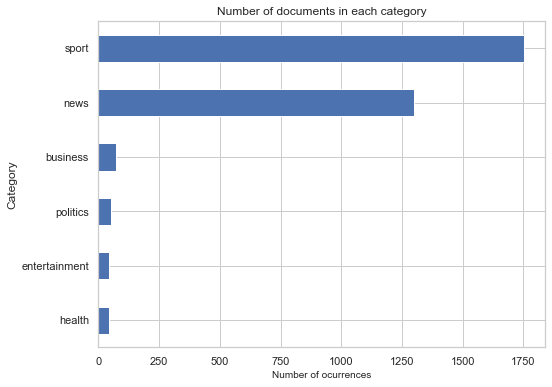

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# set custom sns style
sns.set(style="whitegrid")

fig = plt.figure(figsize=(8,6))
df.groupby(LABEL)[FEATURES[0]].count().sort_values().plot.barh(
    ylim = 0, 
    title = 'Number of documents in each category'
    )
plt.xlabel('Number of ocurrences', fontsize = 10)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=df[LABEL].values, 
            yticklabels=df[LABEL].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC", size=16)

ValueError: multilabel-indicator is not supported